In [9]:
# Linear Regression for DBT Transfer per Transaction
# Keep style similar to the Random Forest notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Data path
DATA_PATH = "../clean_dbt_district_wise.csv"
TEST_SIZE = 0.2
RANDOM_STATE = 42


In [10]:
# Load the dataset
df = pd.read_csv(DATA_PATH)

print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nMissing values per column:")
print(df.isnull().sum())

# Drop rows with missing target if any
if df['transfer_per_transaction'].isnull().sum() > 0:
    df = df.dropna(subset=['transfer_per_transaction']).reset_index(drop=True)

# Encode categorical columns using LabelEncoder (simple, like in RF notebook)
le_state = LabelEncoder()
le_district = LabelEncoder()

# Keep original names for plots
df['state_encoded'] = le_state.fit_transform(df['state_name'])
df['district_encoded'] = le_district.fit_transform(df['district_name'])

# Extract a simple year feature from start_year
df['year'] = df['start_year']

print("\nColumns available:", list(df.columns))


Dataset Shape: (3825, 9)

First 5 rows:
   id         fy         state_name district_name  total_dbt_transfer  no_of_dbt_transactions  start_year  end_year  \
0   0  2019-2020  Jammu And Kashmir      Anantnag           203800000                  720115        2019      2020   
1   1  2019-2020  Jammu And Kashmir        Budgam            54600000                  204443        2019      2020   
2   2  2019-2020  Jammu And Kashmir     Baramulla           246800000                  911993        2019      2020   
3   3  2019-2020  Jammu And Kashmir          Doda            53800000                  243799        2019      2020   
4   4  2019-2020  Jammu And Kashmir         Jammu           442000000                 2277901        2019      2020   

   transfer_per_transaction  
0                283.010353  
1                267.067104  
2                270.616112  
3                220.673588  
4                194.038283  

Missing values per column:
id                           0
fy    

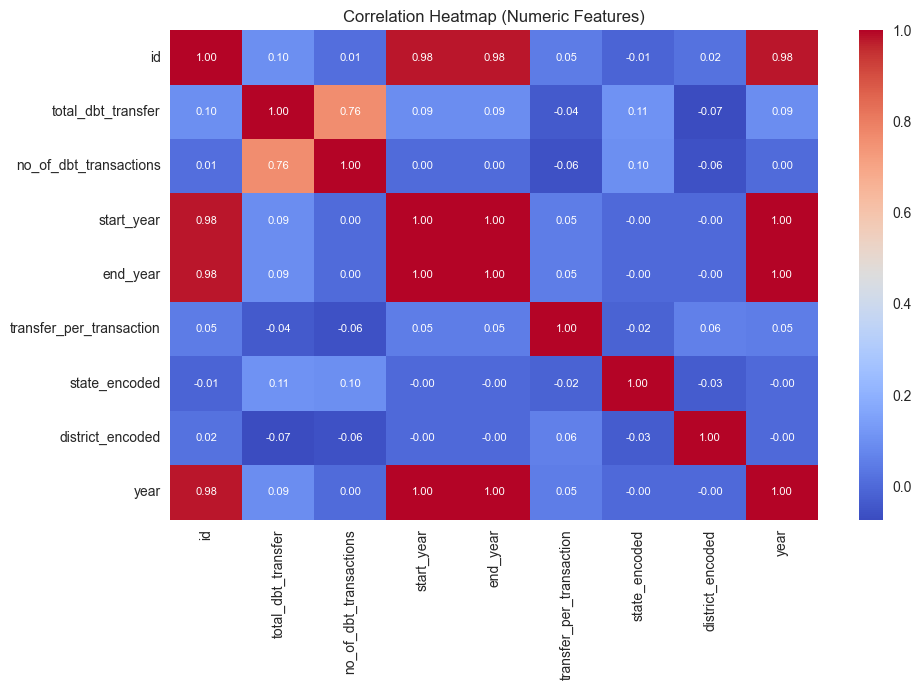

['id',
 'total_dbt_transfer',
 'no_of_dbt_transactions',
 'start_year',
 'end_year',
 'transfer_per_transaction',
 'state_encoded',
 'district_encoded',
 'year']

In [17]:
# Correlation Heatmap (numeric columns)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
plt.figure(figsize=(10, 7))
sns.heatmap(df[num_cols].corr(), cmap='coolwarm', annot=True, fmt='.2f', annot_kws={"size": 8})
plt.title('Correlation Heatmap (Numeric Features)')
plt.tight_layout()
plt.show()

num_cols


In [12]:
# Prepare features and target for Linear Regression
feature_columns = ['state_encoded', 'district_encoded', 'year', 'no_of_dbt_transactions']
X = df[feature_columns]
y = df['transfer_per_transaction']

print(f"Features: {feature_columns}")
print("X shape:", X.shape)
print("y shape:", y.shape)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

print(f"Training size: {X_train.shape[0]}")
print(f"Test size: {X_test.shape[0]}")


Features: ['state_encoded', 'district_encoded', 'year', 'no_of_dbt_transactions']
X shape: (3809, 4)
y shape: (3809,)
Training size: 3047
Test size: 762


In [13]:
# Train Linear Regression
lr = LinearRegression()
print("Training Linear Regression...")
lr.fit(X_train, y_train)

# Predictions
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

# Metrics
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Training RMSE: {train_rmse:,.2f}")
print(f"Test RMSE    : {test_rmse:,.2f}")
print(f"Training MAE : {train_mae:,.2f}")
print(f"Test MAE     : {test_mae:,.2f}")
print(f"Training R^2 : {train_r2:.4f}")
print(f"Test R^2     : {test_r2:.4f}")


Training Linear Regression...
Training RMSE: 6,949.51
Test RMSE    : 10,590.67
Training MAE : 1,111.47
Test MAE     : 1,442.60
Training R^2 : 0.0108
Test R^2     : 0.0042


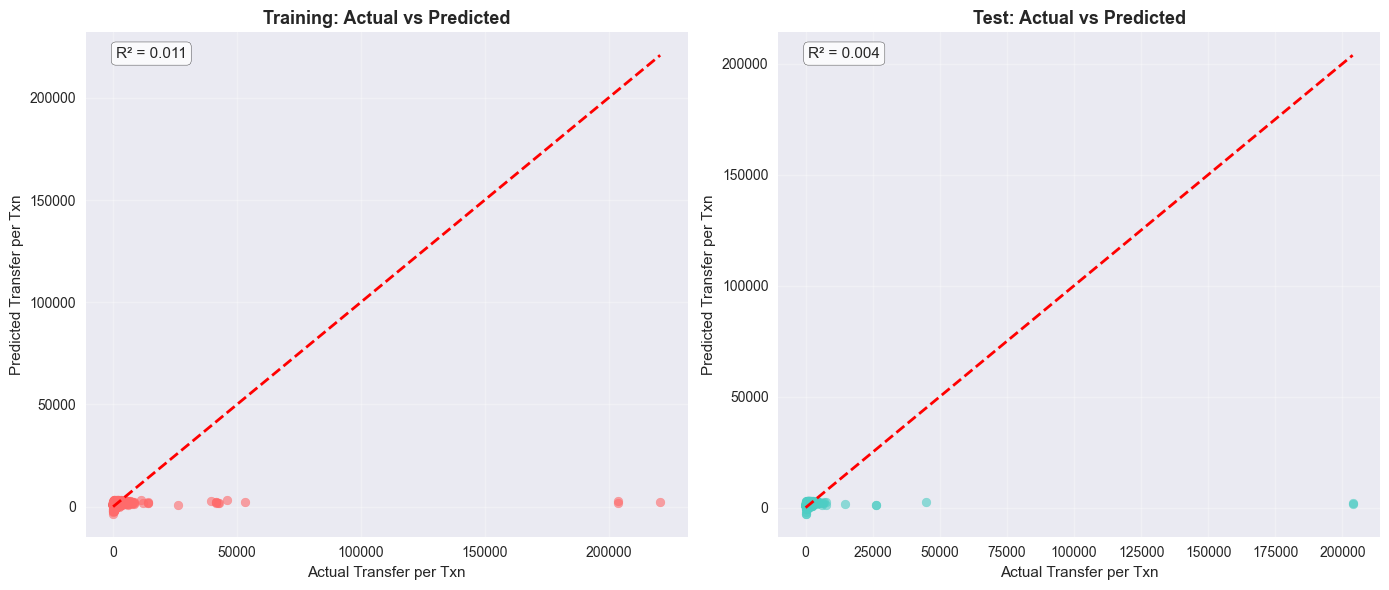

In [14]:
# Actual vs Predicted Scatter Plot (like in RF notebook)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.scatter(y_train, y_train_pred, alpha=0.6, color='#FF6B6B', s=40)
ax1.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
ax1.set_title('Training: Actual vs Predicted', fontsize=13, fontweight='bold')
ax1.set_xlabel('Actual Transfer per Txn')
ax1.set_ylabel('Predicted Transfer per Txn')
ax1.grid(True, alpha=0.3)
ax1.text(0.05, 0.95, f'R² = {train_r2:.3f}', transform=ax1.transAxes,
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8), fontsize=11)

ax2.scatter(y_test, y_test_pred, alpha=0.6, color='#4ECDC4', s=40)
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax2.set_title('Test: Actual vs Predicted', fontsize=13, fontweight='bold')
ax2.set_xlabel('Actual Transfer per Txn')
ax2.set_ylabel('Predicted Transfer per Txn')
ax2.grid(True, alpha=0.3)
ax2.text(0.05, 0.95, f'R² = {test_r2:.3f}', transform=ax2.transAxes,
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8), fontsize=11)

plt.tight_layout()
plt.show()


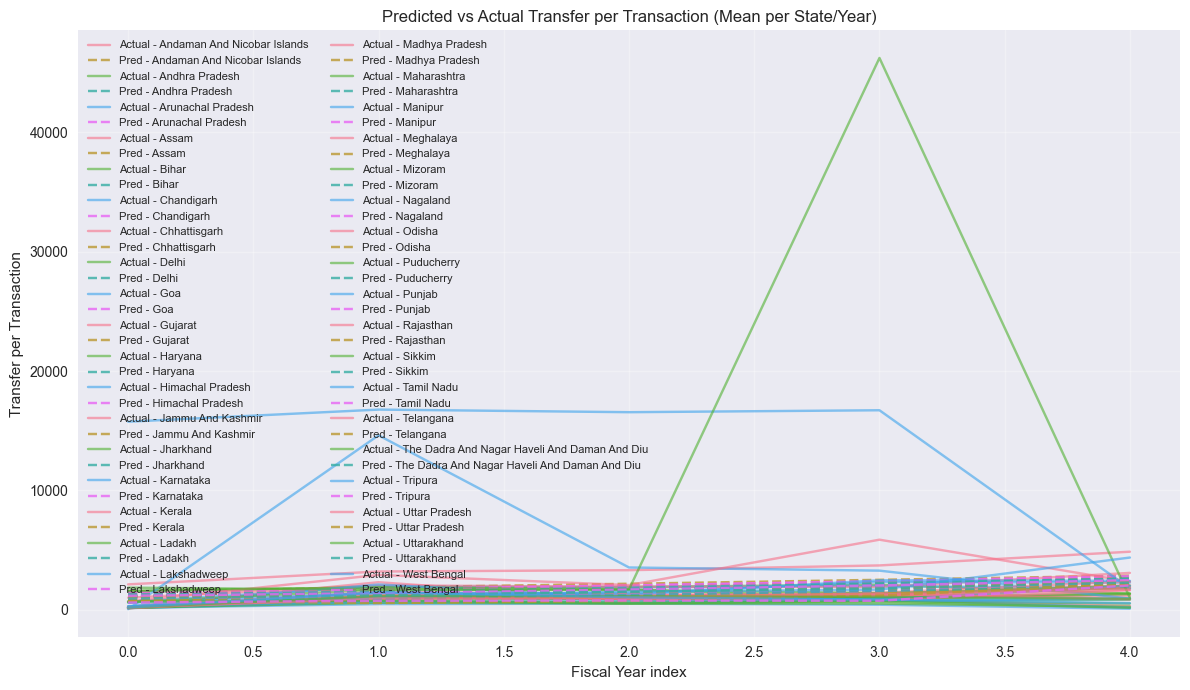

,state_name,fy,actual,predicted
0,Andaman And Nicobar Islands,2019-2020,267.552775,1533.880984
1,Andaman And Nicobar Islands,2020-2021,2313.180061,1869.519115
2,Andaman And Nicobar Islands,2021-2022,861.801437,2187.459340
3,Andaman And Nicobar Islands,2022-2023,858.358617,2516.659744
4,Andaman And Nicobar Islands,2023-2024,322.913732,2861.111247


In [15]:
# Predicted vs Actual line plot (per state/year)
# Predict for full dataset
full_pred = lr.predict(X)
plot_df = df[["state_name", "fy", "transfer_per_transaction"]].copy()
plot_df["predicted"] = full_pred

# Optional: focus on selected states to keep the plot readable
states_to_plot = None  # e.g., ["Jammu And Kashmir", "Haryana", "Punjab"]
if states_to_plot is not None:
    plot_df = plot_df[plot_df["state_name"].isin(states_to_plot)]

# Aggregate mean by state/year
agg = plot_df.groupby(["state_name", "fy"], as_index=False).agg(
    actual=("transfer_per_transaction", "mean"),
    predicted=("predicted", "mean"),
)

plt.figure(figsize=(12, 7))
for state, g in agg.groupby("state_name"):
    xs = np.arange(len(g))
    plt.plot(xs, g["actual"], label=f"Actual - {state}", alpha=0.6)
    plt.plot(xs, g["predicted"], linestyle="--", label=f"Pred - {state}", alpha=0.8)

plt.title("Predicted vs Actual Transfer per Transaction (Mean per State/Year)")
plt.xlabel("Fiscal Year index")
plt.ylabel("Transfer per Transaction")
plt.legend(ncol=2, fontsize=8)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

agg.head()


In [16]:
# Summary of results
print("Linear Regression Summary:")
print("- Algorithm: Linear Regression")
print(f"- Features used: {feature_columns}")
print(f"- Train RMSE: {train_rmse:,.2f}, Test RMSE: {test_rmse:,.2f}")
print(f"- Train MAE : {train_mae:,.2f}, Test MAE : {test_mae:,.2f}")
print(f"- Train R^2 : {train_r2:.3f}, Test R^2 : {test_r2:.3f}")


Linear Regression Summary:
- Algorithm: Linear Regression
- Features used: ['state_encoded', 'district_encoded', 'year', 'no_of_dbt_transactions']
- Train RMSE: 6,949.51, Test RMSE: 10,590.67
- Train MAE : 1,111.47, Test MAE : 1,442.60
- Train R^2 : 0.011, Test R^2 : 0.004
